# Transfer Learning with Tensorflow part 3: Scaling Up

Get helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-20 13:22:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-20 13:22:19 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import *

In [3]:
!nvidia-smi

Mon Jun 20 13:22:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-06-20 13:22:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   182MB/s    in 9.0s    

2022-06-20 13:22:31 (172 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [6]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test'

In [7]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images 

In [8]:
import tensorflow as tf

In [9]:
IMG_SIZE = (224,224)

In [10]:
train_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

test_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
checkpoint_path = '10_pct_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  checkpoint_path,
  save_weights_only = True,
  monitor = 'val_accuracy',
  save_best_only = True
)

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

In [13]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = 'data_augmentation')

In [14]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16719872/16705208 [==============================] - 0s 0us/step


In [15]:
base_model.trainable = False

In [16]:
inputs = layers.Input(shape = (224,224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'global_average_pooiling')(x)

outputs = layers.Dense(len(train_data_10_pct.class_names), activation = 'softmax', name = 'output_layer')(x)

model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooiling (Gl  (None, 1280)             0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [18]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [19]:
history_1 = model.fit(
    train_data_10_pct,
    epochs = 5,
    callbacks = [checkpoint_callback],
    validation_data = test_data_10_pct,
    validation_steps = 0.15*len(test_data_10_pct)
)

Epoch 1/5
237/237 [==============================] - 93s 319ms/step - loss: 3.4738 - accuracy: 0.2503 - val_loss: 2.4484 - val_accuracy: 0.4346
Epoch 2/5
237/237 [==============================] - 60s 253ms/step - loss: 2.3439 - accuracy: 0.4578 - val_loss: 2.0249 - val_accuracy: 0.4995
Epoch 3/5
237/237 [==============================] - 53s 224ms/step - loss: 1.9700 - accuracy: 0.5271 - val_loss: 1.8627 - val_accuracy: 0.5239
Epoch 4/5
237/237 [==============================] - 49s 205ms/step - loss: 1.7538 - accuracy: 0.5688 - val_loss: 1.7688 - val_accuracy: 0.5402
Epoch 5/5
237/237 [==============================] - 48s 202ms/step - loss: 1.6041 - accuracy: 0.6098 - val_loss: 1.7283 - val_accuracy: 0.5449


In [20]:
model.evaluate(test_data_10_pct)

790/790 [==============================] - 59s 74ms/step - loss: 1.7287 - accuracy: 0.5470


[1.7286596298217773, 0.5470098853111267]

### Fine Tuning

First unfreeze every layer in base model

In [21]:
base_model.trainable = True

# Then refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [22]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooiling True
output_layer True


In [24]:
fine_tune_epochs = 2

history = model.fit(
    train_data_10_pct,
    epochs = fine_tune_epochs,
    validation_steps = 0.05*len(test_data_10_pct),
    validation_data = test_data_10_pct,
    initial_epoch = history_1.epoch[-1]
)

In [25]:
preds_probs = model.predict(test_data_10_pct)

In [26]:
len(test_data_10_pct)

790

In [27]:
preds_probs.shape

(25250, 101)

In [28]:
preds_probs[0]

array([3.64039006e-05, 8.95032572e-05, 7.86023593e-05, 1.03872502e-02,
       9.86523274e-03, 7.24902470e-03, 1.41256930e-06, 1.42505085e-02,
       1.05893305e-05, 1.41469543e-04, 1.02244390e-04, 2.41544843e-03,
       3.31253650e-05, 1.24897459e-03, 1.86263482e-04, 5.89376641e-03,
       2.88479387e-05, 2.62115587e-04, 4.11295623e-05, 9.35647578e-04,
       1.21860889e-04, 4.74851622e-05, 9.80352888e-06, 9.86176601e-05,
       2.53921758e-06, 2.79104020e-02, 2.59553362e-03, 2.24983887e-06,
       1.19441291e-02, 3.24937855e-06, 5.48549451e-06, 4.37126837e-05,
       8.45409231e-05, 1.19275041e-03, 4.66675847e-05, 7.63489734e-05,
       1.14852749e-03, 1.70144178e-02, 4.42563731e-04, 7.26266997e-04,
       1.13497721e-04, 3.81461768e-06, 2.91373981e-05, 4.62739154e-05,
       4.48071660e-05, 5.96765713e-05, 2.30651713e-05, 1.89263461e-04,
       6.32610079e-03, 2.15178519e-03, 3.86882573e-03, 8.00924783e-04,
       8.95840349e-05, 7.59750651e-03, 1.21129015e-05, 1.31763367e-03,
      

In [29]:
y_labels = []
for images, label in test_data_10_pct.unbatch():
  y_labels.append(label.numpy().argmax())

In [30]:
len(y_labels)

25250

In [31]:
y_labels[:10]

[6, 11, 96, 76, 62, 5, 21, 97, 45, 77]

In [32]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [35]:
class_names = test_data_10_pct.class_names

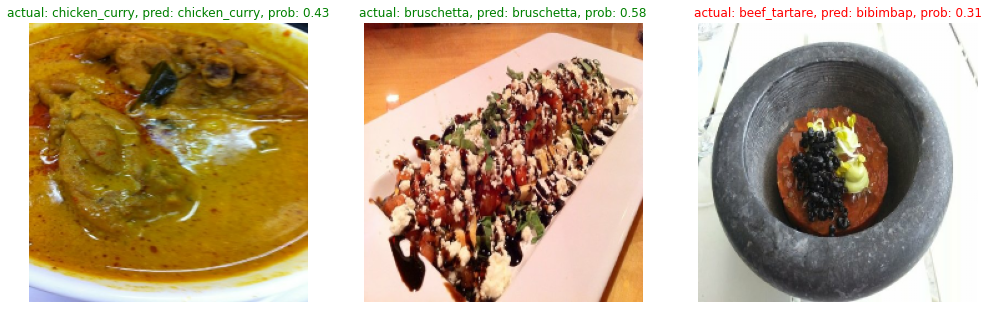

In [39]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + '/' + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Test out the Model on Custom Images

In [40]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2022-06-20 14:03:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.04s   

2022-06-20 14:03:34 (293 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [41]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg']

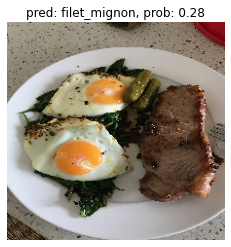

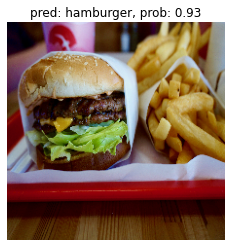

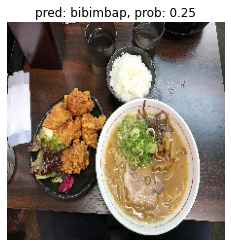

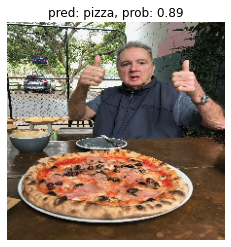

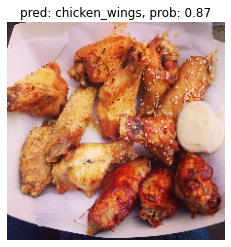

In [42]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

### Finding Most Wrong Predictions

In [ ]:
filepaths = []
for filepath in test_data_10_pct.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()